In [1]:
#July 13
"""
Starting to look for a general LF for many wavelengths (Optical and UV).
"""

import ares
import numpy as np
import matplotlib.pyplot as pl

In [2]:
data = ares.analysis.GalaxyPopulation() #for lit values
pop_halo = ares.populations.HaloPopulation()


### Star-forming galaxies, 
good approximation to generate their spectra assuming they’ve been forming stars at a constant rate for quite awhile. 

In [3]:
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(pop_sed='eldridge2009', pop_tsf=12)

pop = ares.populations.GalaxyPopulation(**base_pars)

pop_sed='eldridge2009', for example, the src attribute in your GalaxyHOD class will make this assumption, and the method L_per_sfr will return the luminosity (at some wavelength you specify) of a constant SFR population with an age set by the pop_tsf parameter (in Myr).

In [4]:
wavelength = np.linspace(500, 2000, 100)

L = [pop.src.L_per_sfr(l) for l in wavelength]
#L_per_sfr : [erg / s / Hz / (Msun / yr)]

# pl.plot(wavelength, L)

# Loaded $ARES/input/bpass_v1/SEDS/sed.bpass.constant.nocont.sin.z020


In [5]:
def getParams(z):

    logM_0 = 11.88 #(0.01)
    mu = 0.019 #(0.002)
    N_0 = 0.0282 #(0.0003)
    nu = -0.72 #(0.06)
    gamma_0 = 0.556 #0.001
    gamma_1 = -0.26 #(0.05)
    beta_0 = 1.06 #(0.06)
    beta_1 = 0.17 #(0.12)

    #Redshift-dependent parameterizations
    N = N_0 * (z + 1)**nu
    M_1 = 10**(logM_0*(z+1)**mu)
    beta = beta_1*z+beta_0
    gamma = gamma_0*(z + 1)**gamma_1
    
    return N, M_1, beta, gamma

$L_{per SFR}(\lambda) \cdot SFR(z, Hm) = Lum_{\lambda} $   [erg/s/Hz], for a given wavelength $\lambda$   
then we need to bin the Lum to get $\phi(M_{\lambda})$ [mag$^{-1}$cMpc$^{-3}$], this is done by:

$\frac{dM_h}{dLum_{\lambda}} \cdot \frac{dn}{dM_h} = \phi(M_{\lambda})$, but I'll need to get $\frac{dM_h}{dLum_{\lambda}}$ numerically.    

In [6]:
def dL_dM(z, Lum, Hm):
    
    diff = []
    for i in range(len(Lum)-1):
        diff.append( (Lum[i+1] - Lum[i])/(Hm[i+1] - Hm[i]) )
        
#     print(diff)
    return diff

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
L_per_sfr: 7.098647621628551e+27
[-7.56804354e+28 -7.55715239e+28 -7.54626123e+28 ...  2.59562208e+28
  2.59823836e+28  2.60085464e+28]


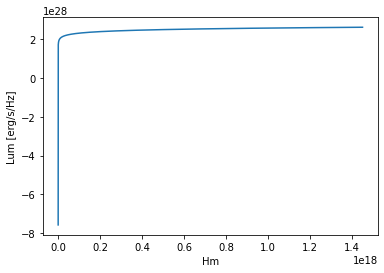

[3.14777909e+23 3.07612689e+23 3.00610570e+23 ... 8.29113198e+08
 8.10240277e+08 7.91796957e+08]
[2.42160015 2.31507894 2.21324706 ... 0.         0.         0.        ]


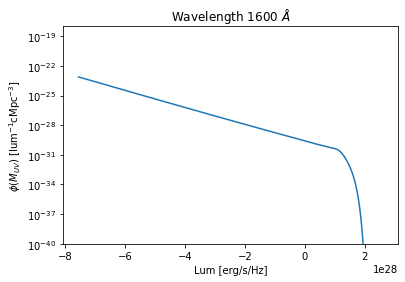

In [7]:
lamda = 1600 #A
z = 1

Lsun = ares.physics.Constants.lsun

Hm = pop_halo.halos.tab_M
# Hm = np.linspace(10, 15, 20)

# [erg / s / Hz / (Msun / yr)] * (Msun)

print("L_per_sfr: {}".format(pop.src.L_per_sfr(lamda)))

Lum = pop.src.L_per_sfr(lamda) * pop.SFR(z, Hm, True, log10=False) #[erg/s/Hz]
# i want to do / ares.physics.Constants.g_per_msun as it makes the numbers bigger 
# (maybe too big) but that seems wrong

print(Lum)

pl.plot(Hm, Lum)
pl.xlabel('Hm')
pl.ylabel('Lum [erg/s/Hz]')
pl.show()

dLdM = np.abs(dL_dM(z, Lum, Hm))
print(dLdM)

k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
dndM = pop_halo.halos.tab_dndm[k, :][:-1]
print(dndM)

LF = dndM/dLdM

# print(LF)

#could put lum in term of lsun = 3.839e33

pl.semilogy(Lum[:-1], LF)

pl.ylabel('$\phi(M_{UV})$ [lum$^{-1}$cMpc$^{-3}$]')
pl.xlabel('Lum [erg/s/Hz]')
pl.title('Wavelength {} $\AA$'.format(lamda))

# pl.ylim(1e-15,)
pl.ylim(1e-40,1e-18)

pl.show()

In [8]:
print(dLdM) #is this too big

print(dndM) #or this too small?
#also goes to 0 at some point - but this isn't mine, should be correct

print(LF)

[3.14777909e+23 3.07612689e+23 3.00610570e+23 ... 8.29113198e+08
 8.10240277e+08 7.91796957e+08]
[2.42160015 2.31507894 2.21324706 ... 0.         0.         0.        ]
[7.69304349e-24 7.52595395e-24 7.36250579e-24 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


[         nan          nan          nan ... -19.44075894 -19.44185277
 -19.44294549]


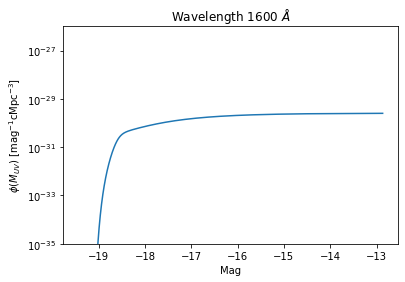

In [13]:
MagSys = ares.util.MagnitudeSystem()
mag = MagSys.L_to_MAB(Lum, z=z)
print(mag) #all nans for z = 0

pl.semilogy(mag[:-1], LF)

pl.ylabel('$\phi(M_{UV})$ [mag$^{-1}$cMpc$^{-3}$]')
pl.xlabel('Mag')
pl.title('Wavelength {} $\AA$'.format(lamda))

pl.ylim(1e-35,1e-26)
# pl.ylim(1e-10,)

pl.show()

### Quiescent galaxies  
the key thing we’ll need to know is the age of their stellar populations, or equivalently, the time when these galaxies stopped forming stars. 

To start, perhaps we could parameterize this age in some simple way:   
- assume that the quenching time (or redshift) is a gaussian?   
- Would allow us to say, for a galaxy in a halo of some mass Mh, there’s an X% probability that it quenched at redshift z.   
- Naturally give rise to a distribution of ages, which could be generalized to allow for an mh-dep quenching distribution.


In [35]:
#what are the units/size of this?
# np.random.normal(loc=0.0, scale=1.0, size=None)

#how does it change with Mh?